Use SMOTE to upsample minority class and gridsearch

In [2]:
#Installing imblearn
#!pip install -U imbalanced-learn

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 50)

In [4]:
%%time
df = pd.read_parquet('../data/approved.parquet', engine='fastparquet')

Wall time: 7.33 s


In [5]:
df.sample(5)

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,installment,int_rate,issue_d,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,verification_status,zip_code,loan_status
id,,,,,,,,,,,,,,,,,,,,,,,,,,
625251,NC,52800.0,Individual,Cash,29.66,1996-08-01,6,Director of Communication,679.0,675.0,E,MORTGAGE,f,378.67,20.99,2015-01-01,14000.0,11.0,0.0,0.0,credit_card,E4,60,Not Verified,275xx,1
65332189,TX,114000.0,Individual,Cash,20.27,2006-11-01,7,Senior Manager,709.0,705.0,D,RENT,f,672.16,15.41,2015-11-01,28000.0,13.0,0.0,0.0,credit_card,D1,60,Verified,787xx,1
71816772,LA,72700.0,Individual,Cash,37.64,1990-01-01,6,Chem Driver,729.0,725.0,D,MORTGAGE,w,926.89,17.27,2016-02-01,25900.0,5.0,0.0,0.0,debt_consolidation,D2,36,Verified,707xx,1
5334835,MI,46000.0,Individual,Cash,23.63,2003-10-01,2,Rco enginerring,684.0,680.0,C,OWN,f,343.39,14.33,2013-05-01,10000.0,7.0,0.0,0.0,debt_consolidation,C1,36,Not Verified,481xx,1
11925452,CA,42000.0,Individual,Cash,27.86,2002-10-01,2,hvac teck,689.0,685.0,D,RENT,f,310.76,18.92,2014-02-01,12000.0,5.0,0.0,0.0,debt_consolidation,D4,60,Verified,950xx,0


### Feature Engineering

In [6]:
df['days_cr_line']=df['issue_d']-df['earliest_cr_line']
#convert to int (https://www.codegrepper.com/code-examples/python/pandas+timedelta64+ns+to+float)
df['days_cr_line'] = (df['days_cr_line'] / np.timedelta64(1,'D')).astype(int)

### Convert Ordinals

In [7]:
# sub_grade
df.sub_grade.replace({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 'B1':6, 'B2':7, 
                      'B3':8, 'B4':9, 'B5':10, 'C1':11, 'C2':12, 'C3':13, 'C4':14, 
                      'C5':15, 'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20, 'E1':21, 
                      'E2':22, 'E3':23, 'E4':24, 'E5':25}, inplace=True)

# disbursement_method
df.disbursement_method.replace({'Cash':0,'DirectPay':1},inplace=True)

# verification_status
df.verification_status.replace({'Source Verified':'Verified'},inplace=True)
df.verification_status.replace({'Not Verified':0,'Verified':1}, inplace=True)

# initial_list_status
df.initial_list_status.replace({'w':0,'f':1}, inplace=True)

# application_type
df.application_type.replace({'Individual':0,'Joint App':1}, inplace=True)

### Dummification

In [8]:
dummies=['purpose','addr_state','home_ownership']

for d in dummies:
    temp = pd.get_dummies(df[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(df[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    df = pd.concat([df.drop(d, axis=1),temp], axis=1)
    #merge back with main df

### Drop Columns

In [9]:
df.drop(['emp_title','zip_code','grade','issue_d','earliest_cr_line'],axis=1, inplace=True)
#remove earliest_cr_line when fixed

### Drop Rows

In [10]:
df.drop(df[df['emp_length']==-1].index, inplace=True)

# Modelling

### create target and features

In [11]:
target = df['loan_status']

In [12]:
target.value_counts()

1    997634
0    229388
Name: loan_status, dtype: int64

In [13]:
features = df.drop(['loan_status'], axis=1)

### note the reduced train_size of .10 = ~120,000 obs

In [14]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.10 )
logr = LogisticRegression()

In [15]:
logr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### SMOTE to oversample minority class

In [16]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(Xtrain, ytrain)

Wall time: 14.6 s


In [17]:
print(y_oversample.value_counts())
print(ytest.value_counts())

1    99949
0    99949
Name: loan_status, dtype: int64
1    897685
0    206635
Name: loan_status, dtype: int64


### gridsearch

In [18]:
Cs = [0.0001,0.001,0.01,1,10,100,1000,10000]
params = [{'C':Cs, 'penalty':['l1','l2']}]
grid_logr = GridSearchCV(estimator=logr, param_grid=params, cv=3)

In [19]:
%%time
grid_logr.fit(X_oversample, y_oversample)

Wall time: 54.9 s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                          'penalty': ['l1', 'l2']}])

In [20]:
print(grid_logr.best_params_)
print(grid_logr.best_score_)

{'C': 0.01, 'penalty': 'l2'}
0.64515402630952


In [21]:
best_model = grid_logr.best_estimator_
best_model.score(Xtest,ytest)

0.6503024485656331

In [22]:
coefs = pd.DataFrame(abs(best_model.coef_).T, index=features.columns)

In [23]:
coefs.sort_values(0, ascending=False).head(10)

,0
sub_grade,0.043926
term,0.041685
int_rate,0.036030
dti,0.028586
open_acc,0.009068
emp_length,0.004768
fico_range_low,0.002711
initial_list_status,0.002577
purpose__credit_card,0.002240
installment,0.002119


### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
cmat = confusion_matrix(ytest,best_model.predict(Xtest))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])


,Pred_0,Pred_1
True_0,128102,78533
True_1,307645,590040


### Best model is one that strikes good balance of a high "pred_1 precision" and a high "loan approval rate"

In [26]:
cmat=cmat
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 0.61
precision pred_1: 0.88
recall pred_1: 0.66


In [27]:
from sklearn.metrics import classification_report
print(classification_report(ytest, best_model.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.29      0.62      0.40    206635
           1       0.88      0.66      0.75    897685

    accuracy                           0.65   1104320
   macro avg       0.59      0.64      0.58   1104320
weighted avg       0.77      0.65      0.69   1104320



### change the threshold to improve the pred_1 precision

In [48]:
probs_positive_class = best_model.predict_proba(Xtest)[:, 1] #isolates probability for pred_1
prediction = probs_positive_class > .6 #converts to true/false boolean. can be inputted into confusion matrix now

In [49]:
cmat2 = confusion_matrix(ytest, prediction)
pd.DataFrame(cmat2, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])

,Pred_0,Pred_1
True_0,166949,39686
True_1,495452,402233


In [30]:
from sklearn.metrics import classification_report
print(classification_report(ytest, prediction))

              precision    recall  f1-score   support

           0       0.25      0.81      0.38    206635
           1       0.91      0.45      0.60    897685

    accuracy                           0.52   1104320
   macro avg       0.58      0.63      0.49   1104320
weighted avg       0.79      0.52      0.56   1104320



In [31]:
cmat=cmat2
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 0.40
precision pred_1: 0.91
recall pred_1: 0.45


### Loop to check thresholds

In [34]:
thresholds = np.linspace(0.5,1,19)

for i in thresholds:
    probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
    prediction = probs_positive_class > i
    cmat = confusion_matrix(ytest, prediction, labels=[0, 1])
    print(f'threshold:{i:.2f}')
    print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
    print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
    print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')
    print("-"*50)

threshold:0.50
loan approval rate: 0.61
precision pred_1: 0.88
recall pred_1: 0.66
--------------------------------------------------
threshold:0.53
loan approval rate: 0.55
precision pred_1: 0.89
recall pred_1: 0.60
--------------------------------------------------
threshold:0.56
loan approval rate: 0.50
precision pred_1: 0.90
recall pred_1: 0.55
--------------------------------------------------
threshold:0.58
loan approval rate: 0.44
precision pred_1: 0.91
recall pred_1: 0.49
--------------------------------------------------
threshold:0.61
loan approval rate: 0.38
precision pred_1: 0.91
recall pred_1: 0.42
--------------------------------------------------
threshold:0.64
loan approval rate: 0.32
precision pred_1: 0.92
recall pred_1: 0.36
--------------------------------------------------
threshold:0.67
loan approval rate: 0.26
precision pred_1: 0.93
recall pred_1: 0.30
--------------------------------------------------
threshold:0.69
loan approval rate: 0.20
precision pred_1: 0.94

## ROC Curve

In [29]:
from sklearn.metrics import roc_curve

In [31]:
# predict probabilities
yhat = logr.predict_proba(Xtest)

In [32]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [48]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

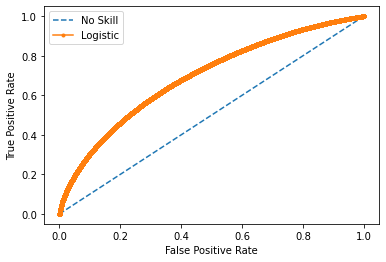

In [49]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [50]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, prediction)

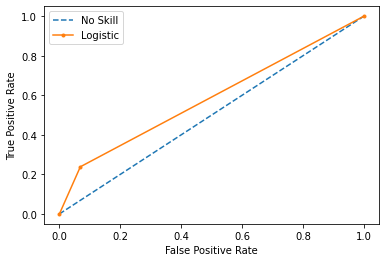

In [51]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### SGD classifier

### Save model in pickle

In [ ]:
filename = 'grid_logr_model.sav'
pickle.dump(grid_logr, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
print(result)